# DataFusion RASAR -- Binary

My very first attempt is to use distances/similarities with other endpoint and effect, thus I don't use distances eith endpoint LC50 effect Mortality.

In [4]:
from helper_datafusion import *
db_mortality = pd.read_csv('data/lc_db_processed.csv')
dist_datafusion = pd.read_csv('data/datafusion_distances.csv').drop(columns = 'Unnamed: 0')
accs = []
rmse = []
sens = []
precs = []
specs = []

kf = KFold(n_splits = 5, shuffle = True)
for train_index, test_index in kf.split(db_mortality):
    X_train = dist_datafusion.iloc[train_index]
    X_test = dist_datafusion.iloc[test_index]
    
    y_train = np.where(db_mortality.conc1_mean.iloc[train_index]>1,1,0)
    y_test =  np.where(db_mortality.conc1_mean.iloc[test_index]>1,1,0)
    
    clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accs.append(accuracy_score(y_test, y_pred))
    rmse.append(sqrt(mean_squared_error(y_test, y_pred)))
    sens.append(recall_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred))
    specs.append(tn/(tn+fp)) 
        
avg_acc = np.mean(accs)
se_acc = sem(accs)

avg_rmse = np.mean(rmse)
se_rmse = sem(rmse)

avg_sens = np.mean(sens)
se_sens = sem(sens)

avg_precs = np.mean(precs)
se_precs = sem(precs)

avg_specs = np.mean(specs)
se_specs = sem(specs)

print('''Accuracy: \t {}, se: {}
RMSE: \t\t {}, se: {}
Sensitivity: \t {}, se: {}
Precision: \t {}, se: {}
Specificity: \t {}, se: {}'''.format(avg_acc, se_acc, avg_rmse, se_rmse, avg_sens, se_sens,
                                 avg_precs, se_precs, avg_specs, se_specs))


 Accuracy: 	 0.8980482894941753, se: 0.0018325912430409545
RMSE: 		 0.31924754468619077, se: 0.0028598827626033878
Sensitivity: 	 0.9267267034000574, se: 0.0022623920309544515
Precision: 	 0.9107334547713885, se: 0.0018184925686037222
Specificity: 	 0.8510175890284625, se: 0.003422215436299718


Second attempt is like the previous but now instead, I'm using distances of the same endpoint/effect of the data too. This result is not definitive because I have to add the information regarding if an experiment has a "copy" in another endpoint/effect.

In [1]:
from helper_datafusion import *

db_mortality, db_datafusion = load_datafusion_datasets('data/lc_db_processed.csv', 'data/datafusion_db_processed.csv')

categorical = ['class', 'tax_order', 'family', 'genus', "species", 'control_type', 'media_type',
               'application_freq_unit',"exposure_type", "conc1_type", 'obs_duration_mean']

non_categorical = ['ring_number', 'tripleBond', 'doubleBond', 'alone_atom_number', 'oh_count',
               'atom_number', 'bonds_number', 'Mol', 'MorganDensity', 'LogP']

X = db_mortality.drop(columns = 'conc1_mean').copy()
y = db_mortality.conc1_mean.values

del db_mortality

acc, se_acc, rmse, se_rmse = cv_datafusion_rasar(X, y, db_datafusion)

Computing distance matrix... Wed Sep 23 16:24:27 2020
Start CV... Wed Sep 23 16:36:38 2020
...END DataFusion RASAR Wed Sep 23 18:29:05 2020
Accuracy: 	 0.9158905337316472, se: 0.0010349961873023007
    RMSE: 		 0.28999439474586375, se: 0.0017830650810416518
    Sensitivity: 	 0.9401460366673255, se: 0.0012092713925737277
    Precision: 	 0.9255970378295088, se: 0.002227388127143637
    Specificity: 	 0.8761245417891879, se: 0.003097701308387638


Adding the last information, this is the final result. The internal random forest hasn't been trained yet.

In [1]:
from helper_datafusion import *

db_mortality, db_datafusion = load_datafusion_datasets('data/lc_db_processed.csv', 'data/datafusion_db_processed.csv')

categorical = ['class', 'tax_order', 'family', 'genus', "species", 'control_type', 'media_type',
               'application_freq_unit',"exposure_type", "conc1_type", 'obs_duration_mean']

non_categorical = ['ring_number', 'tripleBond', 'doubleBond', 'alone_atom_number', 'oh_count',
               'atom_number', 'bonds_number', 'Mol', 'MorganDensity', 'LogP']

X = db_mortality.drop(columns = 'conc1_mean').copy()
y = db_mortality.conc1_mean.values

del db_mortality

acc, se_acc, rmse, se_rmse = cv_datafusion_rasar(X, y, db_datafusion)

Computing distance matrix... Wed Sep 30 19:53:46 2020
Start CV... Wed Sep 30 20:06:23 2020
...END DataFusion RASAR Wed Sep 30 23:53:03 2020
Accuracy: 	 0.9162632576210836, se: 0.0013762670227164399
    RMSE: 		 0.28933361298273474, se: 0.0023876126818164834
    Sensitivity: 	 0.9428085364055028, se: 0.0016882331302965604
    Precision: 		 0.9238643749281898, se: 0.0017699893180723708
    Specificity: 	 0.8726668701223321, se: 0.0017197721322683227


To train the internal RF, first, I have to know the depth of the trees, so I tuned it first.

In [1]:
from helper_datafusion import *
from sklearn.model_selection import train_test_split

db_mortality, db_datafusion = load_datafusion_datasets('data/lc_db_processed.csv', 'data/datafusion_db_processed.csv')

X = db_mortality.drop(columns = 'conc1_mean').copy()
y = db_mortality.conc1_mean.values

X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.33, random_state = 42)

del db_mortality, _, X, y

train_acc, train_rmse, test_acc, test_rmse = cv_depth_datafusion_rasar(X_train, y_train, db_datafusion,
                                                        max_depth_list = [int(i) for i in np.linspace(5,40,10)])

Computing distance matrix... Fri Oct  2 14:48:09 2020
Start CV... Fri Oct  2 14:53:32 2020
Train and test done... models...done
Train and test done... models...done
Train and test done... models...done
Train and test done... models...done
Train and test done... models...done
...END CV Fri Oct  2 17:19:33 2020


In [17]:
tab_depth_rasar = pd.DataFrame(columns = ['train_acc', 'test_acc', 'train_rmse', 'test_rmse'])

tab_depth_rasar.loc[:,'train_acc'] = pd.DataFrame(train_acc).mean(axis = 0)
tab_depth_rasar.loc[:,'test_acc'] = pd.DataFrame(test_acc).mean(axis = 0)
tab_depth_rasar.loc[:,'train_rmse'] = pd.DataFrame(train_rmse).mean(axis = 0)
tab_depth_rasar.loc[:,'test_rmse'] = pd.DataFrame(test_rmse).mean(axis = 0)
tab_depth_rasar

,train_acc,test_acc,train_rmse,test_rmse
5,0.894640,0.888691,0.324571,0.333526
8,0.919590,0.900756,0.283553,0.314955
12,0.957675,0.904982,0.205707,0.308229
16,0.988894,0.905316,0.105302,0.307660
20,0.998318,0.903147,0.040948,0.311187
24,0.999305,0.902813,0.026325,0.311741
28,0.999305,0.903481,0.026325,0.310661
32,0.999305,0.902647,0.026325,0.312004
36,0.999305,0.903592,0.026325,0.310486
40,0.999305,0.902869,0.026325,0.311634


In [18]:
tab_depth_rasar.to_csv('output/datafusion_tuning_depth.csv')

Text(0.5, 0, 'Depth')

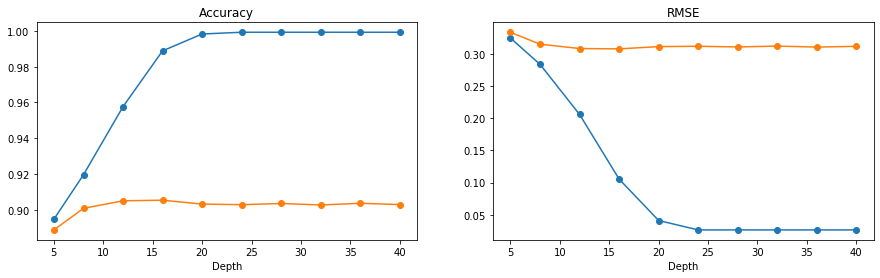

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
plt.plot(tab_depth_rasar.index, tab_depth_rasar['train_acc'], '-o')
plt.plot(tab_depth_rasar.index, tab_depth_rasar['test_acc'], '-o')
plt.title('Accuracy')
plt.xlabel('Depth')

plt.subplot(1,2,2)
plt.plot(tab_depth_rasar.index, tab_depth_rasar['train_rmse'], '-o')
plt.plot(tab_depth_rasar.index, tab_depth_rasar['test_rmse'], '-o')
plt.title('RMSE')
plt.xlabel('Depth')

Then, I choose the interval [10,20] because the metrics are maximized. Finally, other hyperparameters are trained.

In [1]:
from helper_datafusion import *
from sklearn.model_selection import train_test_split

db_mortality, db_datafusion = load_datafusion_datasets('data/lc_db_processed.csv', 'data/datafusion_db_processed.csv')

categorical = ['class', 'tax_order', 'family', 'genus', "species", 'control_type', 'media_type',
               'application_freq_unit',"exposure_type", "conc1_type", 'obs_duration_mean']

non_categorical = ['ring_number', 'tripleBond', 'doubleBond', 'alone_atom_number', 'oh_count',
               'atom_number', 'bonds_number', 'Mol', 'MorganDensity', 'LogP']

X = db_mortality.drop(columns = 'conc1_mean').copy()
y = db_mortality.conc1_mean.values

X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.33, random_state = 42)

del db_mortality, _, X, y

hyper_params_tune = {'max_depth' : [i for i in range(10,20,2)],
                     'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 11)],
                     'min_samples_split': [2, 5, 10],
                     'min_samples_leaf': [1, 2, 4]}

params_list, train_acc, train_rmse, test_acc, test_rmse = cv_random_datafusion_rasar(X_train, y_train, db_datafusion,
                                                                       hyper_params_tune)

Computing distance matrix... Sat Oct  3 11:31:18 2020
Start CV... Sat Oct  3 11:36:48 2020
Train and test done... models...done
Train and test done... models...done
Train and test done... models...done
Train and test done... models...done
Train and test done... models...done
...END CV Sat Oct  3 15:28:40 2020


In [5]:
tab_rf_rasar = pd.DataFrame(columns = ['train_acc', 'test_acc', 'train_rmse', 'test_rmse'])

tab_rf_rasar.loc[:,'train_acc'] = pd.DataFrame(train_acc).mean(axis = 0)
tab_rf_rasar.loc[:,'test_acc'] = pd.DataFrame(test_acc).mean(axis = 0)
tab_rf_rasar.loc[:,'train_rmse'] = pd.DataFrame(train_rmse).mean(axis = 0)
tab_rf_rasar.loc[:,'test_rmse'] = pd.DataFrame(test_rmse).mean(axis = 0)
tab_rf_rasar

,train_acc,test_acc,train_rmse,test_rmse
mod0,0.957092,0.905872,0.207137,0.306651
mod1,0.929153,0.902591,0.266163,0.312012
mod2,0.975801,0.904760,0.155525,0.308509
mod3,0.938855,0.904259,0.247272,0.309318
mod4,0.969907,0.904815,0.173463,0.308426
...,...,...,...,...
mod95,0.995622,0.902758,0.066135,0.311778
mod96,0.949864,0.904537,0.223908,0.308834
mod97,0.936187,0.903258,0.252604,0.310920
mod98,0.971408,0.904148,0.169081,0.309503


In [36]:
params_df = pd.DataFrame(params_list, index = ['mod' + str(i) for i in range(0,100)])
tab_rf_rasar = pd.concat([tab_rf_rasar, params_df], axis = 1)
tab_rf_rasar

,train_acc,test_acc,train_rmse,test_rmse,n_estimators,min_samples_split,min_samples_leaf,max_depth
mod0,0.957092,0.905872,0.207137,0.306651,600,10,2,18
mod1,0.929153,0.902591,0.266163,0.312012,760,2,4,10
mod2,0.975801,0.904760,0.155525,0.308509,360,5,1,16
mod3,0.938855,0.904259,0.247272,0.309318,1000,2,4,12
mod4,0.969907,0.904815,0.173463,0.308426,440,2,2,16
...,...,...,...,...,...,...,...,...
mod95,0.995622,0.902758,0.066135,0.311778,840,2,1,18
mod96,0.949864,0.904537,0.223908,0.308834,760,5,4,16
mod97,0.936187,0.903258,0.252604,0.310920,840,5,1,10
mod98,0.971408,0.904148,0.169081,0.309503,520,5,2,18


In [37]:
tab_rf_rasar.to_csv('output/datafusion_tuning_params.csv')

In [38]:
# tab_rf_rasar[tab_rf_rasar.test_acc == tab_rf_rasar.test_acc.max()] 
tab_rf_rasar[tab_rf_rasar.test_rmse == tab_rf_rasar.test_rmse.min()]

,train_acc,test_acc,train_rmse,test_rmse,n_estimators,min_samples_split,min_samples_leaf,max_depth
mod74,0.948794,0.905927,0.226284,0.306554,520,10,4,18


The best model is using:

- Number of internal trees = 520

- Minimum number of samples to decide to split = 10

- Minimum number of samples in a leaf = 4

- Maximum depth of internal trees = 18

Trying this configuration we reach...

In [1]:
from helper_datafusion import *

db_mortality, db_datafusion = load_datafusion_datasets('data/lc_db_processed.csv', 'data/datafusion_db_processed.csv')

categorical = ['class', 'tax_order', 'family', 'genus', "species", 'control_type', 'media_type',
               'application_freq_unit',"exposure_type", "conc1_type", 'obs_duration_mean']

non_categorical = ['ring_number', 'tripleBond', 'doubleBond', 'alone_atom_number', 'oh_count',
               'atom_number', 'bonds_number', 'Mol', 'MorganDensity', 'LogP']

X = db_mortality.drop(columns = 'conc1_mean').copy()
y = db_mortality.conc1_mean.values

del db_mortality

params = {'n_estimators': 1000,
          'min_samples_split': 10,
          'min_samples_leaf': 4,
          'max_depth': 18}

acc, se_acc, rmse, se_rmse = cv_datafusion_rasar(X, y, db_datafusion, params)

Computing distance matrix... Sat Oct  3 20:13:49 2020
Start CV... Sat Oct  3 20:26:38 2020
Train and test...done... model...done
Train and test...done... model...done
Train and test...done... model...done
Train and test...done... model...done
Train and test...done... model...done
...END DataFusion RASAR Sun Oct  4 00:27:59 2020
Accuracy: 	 0.9172688234027124, se: 0.00106329640633587
RMSE: 		 0.28760631936068715, se: 0.001856182984393397
Sensitivity: 	 0.9456815238619593, se: 0.0021229056279538617
Precision: 		 0.923037997134219, se: 0.001836908172293486
Specificity: 	 0.8707344072046809, se: 0.002748283705839851


# Data Fusion RASAR -- Multiclass

In [1]:
from helper_rasar_datafusion_multiclass import *

db_mortality, db_datafusion = load_datafusion_datasets('data/lc_db_processed.csv', 'data/datafusion_db_processed.csv',
                                                      encoding = 'multiclass')

categorical = ['class', 'tax_order', 'family', 'genus', "species", 'control_type', 'media_type',
               'application_freq_unit',"exposure_type", "conc1_type", 'obs_duration_mean']

non_categorical = ['ring_number', 'tripleBond', 'doubleBond', 'alone_atom_number', 'oh_count',
               'atom_number', 'bonds_number', 'Mol', 'MorganDensity', 'LogP']

X = db_mortality.drop(columns = 'conc1_mean').copy()
y = db_mortality.conc1_mean.values

del db_mortality

cv_datafusion_rasar_multiclass(X, y, db_datafusion)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from C:\Users\Simone\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Simone\AppData\Local\Temp\tmpxkbqmg3w
  JVM stdout: C:\Users\Simone\AppData\Local\Temp\tmpxkbqmg3w\h2o_Simone_started_from_python.out
  JVM stderr: C:\Users\Simone\AppData\Local\Temp\tmpxkbqmg3w\h2o_Simone_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,"7 days, 6 hours and 46 minutes"
H2O_cluster_name:,H2O_from_python_Simone_qewune
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.643 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Computing distance matrix... Mon Oct  5 22:15:18 2020
Start CV... Mon Oct  5 22:29:03 2020
Train and test...
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
done... Mon Oct  5 23:10:43 2020 model...
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
done Mon Oct  5 23:11:07 2020
Train and test...
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
done... Mon Oct  5 23:55:29 2020 model...
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
done Mon Oct  5 23:55:49 2020
Train and test...
Parse progress: |██████████████████████████████████████████████

### Depth tuning

In [1]:
from helper_rasar_datafusion_multiclass import *
from sklearn.model_selection import train_test_split

db_mortality, db_datafusion = load_datafusion_datasets('data/lc_db_processed.csv', 'data/datafusion_db_processed.csv',
                                                      encoding = 'multiclass')

X = db_mortality.drop(columns = 'conc1_mean').copy()
y = db_mortality.conc1_mean.values

X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = y)

del db_mortality, _, X, y

max_depth_list = [5, 7, 10, 12, 16, 20, 23, 27, 30, 40]

tab_depth_rasar = cv_depth_datafusion_rasar_multiclass(X_train, y_train, db_datafusion, max_depth_list)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from C:\Users\Simone\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Simone\AppData\Local\Temp\tmplebk10pf
  JVM stdout: C:\Users\Simone\AppData\Local\Temp\tmplebk10pf\h2o_Simone_started_from_python.out
  JVM stderr: C:\Users\Simone\AppData\Local\Temp\tmplebk10pf\h2o_Simone_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_Simone_5nb846
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.643 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Computing distance matrix... Tue Oct 13 23:20:28 2020
Start CV... Tue Oct 13 23:25:54 2020
Train and test... Tue Oct 13 23:25:56 2020Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
done... models... Wed Oct 14 00:08:18 2020drf Grid Build progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0, 3.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0, 3.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0, 3.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0, 3.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0, 3.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0, 3.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0, 3.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0, 3.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0, 3.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0, 3.0]
  warnings.warn(w)


Train and test... Wed Oct 14 00:11:25 2020Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
done... models... Wed Oct 14 00:53:46 2020drf Grid Build progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0]
  warnings.warn(w)


Train and test... Wed Oct 14 00:56:48 2020Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
done... models... Wed Oct 14 01:39:23 2020drf Grid Build progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [4.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [4.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [4.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [4.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [4.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [4.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [4.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [4.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [4.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [4.0]
  warnings.warn(w)


Train and test... Wed Oct 14 01:42:21 2020Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
done... models... Wed Oct 14 02:24:56 2020drf Grid Build progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: 

C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)


...END CV Wed Oct 14 03:13:29 2020


In [2]:
tab_depth_rasar

,max_depth,train_acc,test_acc,train_rmse,test_rmse
0,5,0.689870,0.669966,0.789151,0.813870
1,7,0.723994,0.685922,0.735096,0.778700
2,10,0.791199,0.702157,0.635720,0.747105
3,12,0.845213,0.714111,0.538186,0.729750
4,16,0.944665,0.722673,0.296684,0.712962
5,20,0.982889,0.721061,0.156797,0.713569
6,23,0.989422,0.721783,0.123869,0.712223
7,27,0.991521,0.722117,0.113098,0.712126
8,30,0.991924,0.722562,0.110921,0.712820
9,40,0.992077,0.722506,0.110230,0.713003


In [5]:
tab_depth_rasar.to_csv('output/datafusion_tuning_depth_multiclass.csv')

Text(0.5, 0, 'Depth')

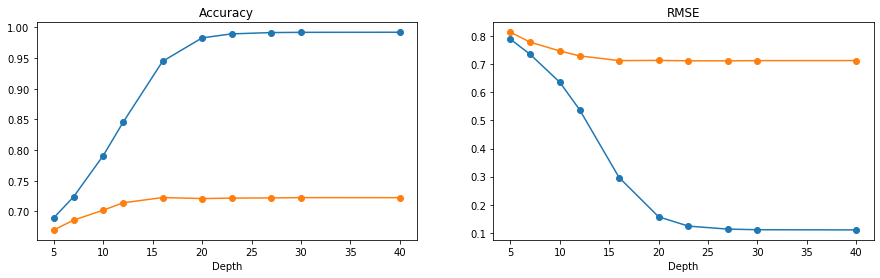

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
plt.plot(tab_depth_rasar['max_depth'], tab_depth_rasar['train_acc'], '-o')
plt.plot(tab_depth_rasar['max_depth'], tab_depth_rasar['test_acc'], '-o')
plt.title('Accuracy')
plt.xlabel('Depth')

plt.subplot(1,2,2)
plt.plot(tab_depth_rasar['max_depth'], tab_depth_rasar['train_rmse'], '-o')
plt.plot(tab_depth_rasar['max_depth'], tab_depth_rasar['test_rmse'], '-o')
plt.title('RMSE')
plt.xlabel('Depth')

### other hyperparameters tuning

In [1]:
from helper_rasar_datafusion_multiclass import *
from sklearn.model_selection import train_test_split

db_mortality, db_datafusion = load_datafusion_datasets('data/lc_db_processed.csv', 'data/datafusion_db_processed.csv',
                                                      encoding = 'multiclass')

X = db_mortality.drop(columns = 'conc1_mean').copy()
y = db_mortality.conc1_mean.values

X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = y)

del db_mortality, _, X, y

hyper_params_tune = {'max_depth' : [15,17,20,23],
                'sample_rate': [x/10 for x in np.linspace(2,8,4)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                'min_rows': [2**x for x in range(0,int(math.log(X_train.shape[0],2)-2)+1)],
                'nbins': [2**x for x in range(4,11)],
                'nbins_cats': [2**x for x in range(4,13)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}


tab_rasar_tune = cv_random_datafusion_rasar_multiclass(X_train, y_train, db_datafusion, hyper_params_tune,
                                                       n_models = 90)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from C:\Users\Simone\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Simone\AppData\Local\Temp\tmpwff4llne
  JVM stdout: C:\Users\Simone\AppData\Local\Temp\tmpwff4llne\h2o_Simone_started_from_python.out
  JVM stderr: C:\Users\Simone\AppData\Local\Temp\tmpwff4llne\h2o_Simone_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_Simone_y71ens
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.643 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Computing distance matrix... Thu Oct 15 12:06:02 2020
Start CV... Thu Oct 15 12:11:25 2020
Train and test... Thu Oct 15 12:11:27 2020done... models... Thu Oct 15 12:55:23 2020done
Train and test... Thu Oct 15 14:43:05 2020done... models... Thu Oct 15 15:26:56 2020

C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not train

C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not train

done
Train and test... Thu Oct 15 17:15:55 2020done... models... Thu Oct 15 17:59:57 2020

C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not train

C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not train

done
Train and test... Thu Oct 15 19:48:48 2020done... models... Thu Oct 15 20:32:50 2020

C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not train

C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not trained on: [2.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_GEN_label' has levels not train

done
Train and test... Thu Oct 15 22:21:21 2020done... models... Thu Oct 15 23:05:42 2020

C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0, 3.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0, 4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0, 3.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0, 4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0, 3.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_la

C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0, 4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0, 3.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0, 4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0, 3.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0, 4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_la

C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0, 3.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0, 4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0, 3.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0, 4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0, 3.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_la

C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0, 4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0, 3.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0, 4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0, 3.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [2.0, 4.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_la

done
...END CV Fri Oct 16 00:51:49 2020


In [3]:
tab_rasar_tune.to_csv('output/datafusion_tuning_params_multiclass.csv')

In [7]:
# tab_rasar_tune[tab_rasar_tune.test_acc == tab_rasar_tune.test_acc.max()] 
tab_rasar_tune[tab_rasar_tune.test_rmse == tab_rasar_tune.test_rmse.min()]

,train_acc,test_acc,train_rmse,test_rmse,sample_rate,nbins_cats,nbins,min_split_improvement,min_rows,max_depth,histogram_type,col_sample_rate_per_tree
mod82,0.979262,0.730734,0.175762,0.701838,0.6,4096,64,0.0001,1,17,QuantilesGlobal,0.83


Miglior modello:
- sample_rate = 0.6

- nbins_cats = 4096

- nbins = 64

- min_split_imporovement = 0.0001

- min_rows = 1

- max_depth = 17

- hystogram_type = QuantilesGlobal

- col_sample_rate_per_tree = 0.83

In [1]:
from helper_rasar_datafusion_multiclass import *

db_mortality, db_datafusion = load_datafusion_datasets('data/lc_db_processed.csv', 'data/datafusion_db_processed.csv',
                                                      encoding = 'multiclass')

categorical = ['class', 'tax_order', 'family', 'genus', "species", 'control_type', 'media_type',
               'application_freq_unit',"exposure_type", "conc1_type", 'obs_duration_mean']

non_categorical = ['ring_number', 'tripleBond', 'doubleBond', 'alone_atom_number', 'oh_count',
               'atom_number', 'bonds_number', 'Mol', 'MorganDensity', 'LogP']

X = db_mortality.drop(columns = 'conc1_mean').copy()
y = db_mortality.conc1_mean.values

del db_mortality

cv_datafusion_rasar_multiclass(X, y, db_datafusion, final_model = True)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from C:\Users\Simone\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Simone\AppData\Local\Temp\tmp__pwxtne
  JVM stdout: C:\Users\Simone\AppData\Local\Temp\tmp__pwxtne\h2o_Simone_started_from_python.out
  JVM stderr: C:\Users\Simone\AppData\Local\Temp\tmp__pwxtne\h2o_Simone_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_Simone_9nkaa9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.643 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Computing distance matrix... Fri Oct 16 08:14:25 2020
Start CV... Fri Oct 16 08:27:10 2020
Train and test...
done... Fri Oct 16 09:32:40 2020 model...
done Fri Oct 16 09:41:48 2020
Train and test...
done... Fri Oct 16 10:49:05 2020 model...
done Fri Oct 16 10:58:07 2020
Train and test...
done... Fri Oct 16 12:05:39 2020 model...
done Fri Oct 16 12:14:45 2020
Train and test...
done... Fri Oct 16 13:23:37 2020 model...


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [2.0]
  warnings.warn(w)


done Fri Oct 16 13:32:44 2020
Train and test...
done... Fri Oct 16 14:39:01 2020 model...


C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'LOEC_BEH_label' has levels not trained on: [1.0]
  warnings.warn(w)
C:\Users\Simone\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'NOEC_CEL_label' has levels not trained on: [3.0]
  warnings.warn(w)


done Fri Oct 16 14:48:22 2020
...END DataFusion RASAR Fri Oct 16 14:48:22 2020
Accuracy: 	 0.7698350798587519, se: 0.0019474804297725378
RMSE: 		 0.6322534289226286, se: 0.007154501519044299
W. Recall: 	 0.7698350798587519, se: 0.0019474804297725378
W. Precision: 	 0.7698540655104382, se: 0.0018698919667617354
